# 3.3 循环神经网络
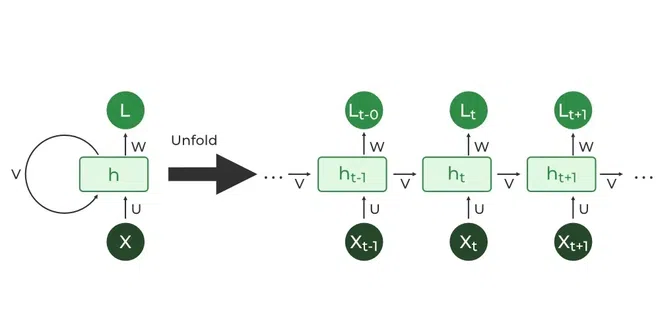

RNN是一种具有循环连接的网络，可以处理任意长度的序列数据。在处理序列的每个时间步时，RNN都会更新其隐藏状态，该隐藏状态是对之前信息的记忆。这节课，我们将使用我们的Tensor类实现一个简单的RNN神经网络

In [1]:
import sys
sys.path.append('.')

In [2]:
import numpy as np
import mytorch
from mytorch import Tensor, nn

首先我们实现cat函数，这个函数是实现将多个矩阵拼接在一起，当然梯度也按照拼接方式进行分割

In [4]:
def cat(tensors, dim=0):
        assert all(isinstance(t, Tensor) for t in tensors), "所有输入必须是Tensor对象"
        data = [t.data for t in tensors]
        concatenated_data = np.concatenate(data, axis=dim)
        
        # 创建一个新的Tensor对象作为cat操作的结果
        out = Tensor(concatenated_data, _prev=tuple(tensors), _op='cat')
        
        def _backward():
            # 分割out.grad并将相应的梯度分配给原始的Tensor对象
            grad_splits = np.split(out.grad, np.cumsum([t.data.shape[dim] for t in tensors[:-1]]), axis=dim)
            for t, grad in zip(tensors, grad_splits):
                t.grad += grad
        
        out._backward = _backward
        return out

我们来测试一下这个cat函数

In [13]:
a = Tensor([[1,2,3]])
b = Tensor([[4,5,6]])
c = cat((a,b))
c

Tensor(data=[[1. 2. 3.]
 [4. 5. 6.]], grad=[[0. 0. 0.]
 [0. 0. 0.]], trainable=True)

In [14]:
a = Tensor([[1,2,3]])
b = Tensor([[4,5,6]])
c = cat((a,b), 1)
c

Tensor(data=[[1. 2. 3. 4. 5. 6.]], grad=[[0. 0. 0. 0. 0. 0.]], trainable=True)

In [3]:
a = Tensor([[1,2,3,4]])
b = Tensor([[4,5,6,7]])
c = mytorch.cat((a,b), 1)
print(c)

Tensor(data=[[1. 2. 3. 4. 4. 5. 6. 7.]], grad=[[0. 0. 0. 0. 0. 0. 0. 0.]], trainable=True)


可以看到我们按照 dim=0 拼接会把两个维度是1✖️3的矩阵变成2✖️3的矩阵，按照 dim=1 拼接会把两个维度是1✖️3的矩阵变成1✖️6的矩阵,现在我们需要把cat()函数放到Tensor类中（当然，在原版的pytorch中是torch.cat()）

现在让我们实现RNN网络

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        combined = Tensor.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        hidden = mytorch.tanh(hidden)
        output = self.h2o(hidden)
        return output, hidden

    def __repr__(self):
        return f"RNN(input_size={self.input_size}, hidden_size={self.hidden_size}, output_size={self.output_size})"

In [8]:
import torch.nn as nn
print(nn.RNN(12,4,12))

RNN(12, 4, num_layers=12)
